### Imp Aspects of any Neural Network
* Weight initialization
* Loss Functions
* Different Layers
* Over-fitting
* Optimization

### Intuition of Activation and Gradients
In the project `build_makemore_mlp.ipynb`, we delved into activation of the neural net (forward pass) and then the gradients that were flowing backwards during the training phase.

**Recurrent Neural Networks (RNN)** are very expressive as universal approximator can in principal can implement all the algorithms, however, they are not very easily optimizable with the gradient based techniques that we saw in building our mlp.

**RNN's are very expressive**\
RNNs are powerful models that can represent very complex patterns. Because RNNs have memory (they pass information from one step to the next), they can model:
* sequences
* time-based data
* dependencies across many steps (e.g., language, speech)

**Universal approximator**\
RNNs can approximate any function or computation, given enough neurons and time. In theory, an RNN can learn any algorithm — like counting, remembering past inputs, or applying rules — just like a computer program.

**Can in principle implement all algorithms**\
If trained perfectly, an RNN could:
* simulate loops
* store information
* make decisions based on past inputs

So in theory, it can perform any step-by-step procedure.

**However, they are not very easily optimizable**
Even though RNNs are powerful, finding the right parameters is hard. Standard training methods (like gradient descent and backpropagation through time) don’t work well for RNNs.

As gradients are passed through many time steps:
* hey often shrink to zero (vanishing gradients)
* or grow too large (exploding gradients)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Lets load the cleaned names dataset prepared in build_makemore.ipynb

import pickle

with open('indian_names_clean.pkl', 'rb') as f:
    names = pickle.load(f)

print(f"Ready! Loaded {len(names)} names")
print("First 10:", names[:10])

Ready! Loaded 64128 names
First 10: ['jyotirmoy', 'ilamuhil', 'indravathi', 'raamen', 'benudhar', 'mithushaya', 'malani', 'sathuna', 'oviyashri', 'vaitheeswarsn']


In [4]:
stoi = {s:i+1 for i, s in enumerate(sorted(list(set(''.join(names)))))}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}
print(f'{stoi}\n{itos}')

{'-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}
{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


In [5]:
vocab_size = len(itos)
vocab_size

28

In [6]:
# build the dataset
block_size = 3

def build_dataset(names):
    X, Y = [], []

    for name in names:
        context = [0] * block_size
        for ch in name + '.':
            index = stoi[ch]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y


In [7]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtrain, Ytrain = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest, Ytest = build_dataset(names[n2:])

torch.Size([458700, 3]) torch.Size([458700])
torch.Size([57308, 3]) torch.Size([57308])
torch.Size([57317, 3]) torch.Size([57317])


In [8]:
# MLP Revisited 
n_embd = 10     # dimensionality of the character embedding vectors (feature vector)
n_hidden = 200  # number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn((n_hidden, vocab_size),        generator=g)
b2 = torch.randn(vocab_size,                    generator=g)

parameters = [C, W1, b1, W2, b2]

print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

Total number of parameters: 12108


In [9]:
for p in parameters:
    p.requires_grad = True

In [10]:
# Optimizations
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch constructs
    indices = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)

    # forward pass
    Xb = Xtrain[indices]                    # batch X
    emb = C[Xb]                             # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    Yb = Ytrain[indices]                    # batch Y
    loss = F.cross_entropy(logits, Yb)      # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01        # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:                             # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())                # log compresses the loss -> better visualization


      0/ 200000: 28.8116
  10000/ 200000: 2.6211
  20000/ 200000: 2.1845
  30000/ 200000: 2.4046
  40000/ 200000: 2.0533
  50000/ 200000: 2.1015
  60000/ 200000: 2.0059
  70000/ 200000: 2.1370
  80000/ 200000: 2.2052
  90000/ 200000: 2.2226
 100000/ 200000: 2.1874
 110000/ 200000: 1.8944
 120000/ 200000: 2.2353
 130000/ 200000: 1.8513
 140000/ 200000: 2.0530
 150000/ 200000: 1.9472
 160000/ 200000: 2.1529
 170000/ 200000: 2.2903
 180000/ 200000: 1.6797
 190000/ 200000: 1.9153


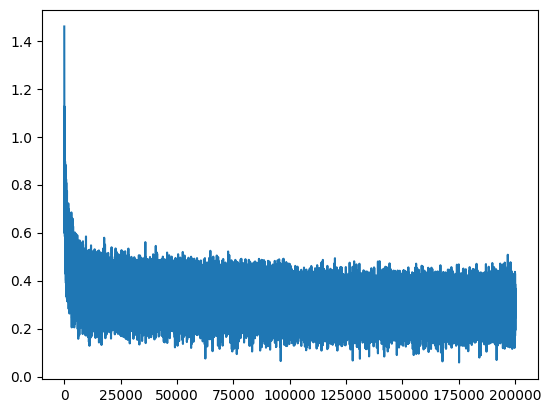

In [11]:
plt.plot(lossi)

**nograd decorator**\
@torch.nograd() decorator does not do any book keeping for keeping track of the gradients \
in anticipation of any backward pass in the future \
torch knows that the function following this decorator, will not require any gradients.

makes the code efficient

In [12]:
@torch.no_grad()            # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]      # N x block_size x n_embd
    embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 +b1)         # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9999867677688599
val 2.0162084102630615


### Sampling from the model

In [55]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):
    guess = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]    # 1 X block_size X dimensionality (number of features)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        index = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [index]
        guess.append(index)

        if index == 0:
            break
    
    guessed_name = ''.join(itos[i] for i in guess).strip('.')

    print(guessed_name) if guessed_name not in names else None


bari
dhruthree
nithayaan
chirozhi
nithirahalaganagtodwuthi
thanthi
vajundinay
abhth
sirikanusikmatharu
par
magethaleenilan
sashika
qam
jeethrameviyshanandishan
akaleen
inth
manilash
sankulag
sauvishwaaya
pan
anksh
